# Ensemble Model Training and Test

In [1]:
import pickle
import pandas as pd
import numpy as np
import re
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import xgboost as xgb
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
with open('./ckpt/train_proc.pkl', mode='rb') as f:
    train = pickle.load(f)
with open('./ckpt/test_proc.pkl', mode='rb') as f:
    test = pickle.load(f)
with open('./ckpt/test_passengerid.pkl', mode='rb') as f:
    passenger = pickle.load(f)

In [3]:
# Some useful parametes which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED)

In [4]:
# Class to extend the sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        return self.clf.feature_importances_
        
# Class to extend XGboost classifier

### Out-of-Fold Predictions

In [5]:
def get_oof(clf, x_train, y_train, x_test, kf):
    # the array of storing the result of kfold validation
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    # for calcurating the prediction mean
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    # split the training dataset into NFOLDS
    kf.get_n_splits(x_train)
    for i, (train_idx, test_idx) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_idx]
        y_tr = y_train[train_idx]
        x_te = x_train[test_idx]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_idx] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    # calcurating the prediction mean
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating out Base First-Level Models

In [6]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    # 'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters
svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

In [7]:
rf = SklearnHelper(clf=RandomForestClassifier , seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier , seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier , seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier , seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC , seed=SEED, params=svc_params)

#### Creating Numpy arrays out of our train and test sets

In [8]:
# Create Numpy arrays of train, test and target(Survived) dataframes to feed into our models
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

In [9]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test, kf) # Random Forest
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test, kf) # Extra Trees
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test, kf) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test, kf) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test, kf) # Support Vector Classifier

print("Training is complete")

Training is complete


#### Feature importances generated from the different classifiers

In [17]:
rf_features = rf.feature_importances(x_train, y_train).tolist()[::-1]
et_features = et.feature_importances(x_train, y_train).tolist()[::-1]
ada_features = ada.feature_importances(x_train, y_train).tolist()[::-1]
gb_features = gb.feature_importances(x_train, y_train).tolist()[::-1]

In [18]:
cols = train.columns.values
# Create a dataframe with features
feature_names = [
    'Random Forest feature importances',
    'Extra Trees feature importances',
    'AdaBoost feature importances',
    'Gradient Boost feature importances'
]
feature_dataframe = pd.DataFrame({'features': cols,
                                  feature_names[0]: rf_features,
                                  feature_names[1]: et_features,
                                  feature_names[2]: ada_features,
                                  feature_names[3]: gb_features})

#### Interactive feature importances via Plotly scatterplots

In [19]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.272955,0.143773,0.068,0.404410
1,Sex,0.013570,0.020225,0.004,0.007908
2,Age,0.067191,0.040400,0.068,0.083313
3,Parch,0.065125,0.077761,0.004,0.032194
4,Fare,0.106910,0.062211,0.696,0.203277
5,Embarked,0.023141,0.031761,0.012,0.027891
6,Name_length,0.070950,0.053520,0.038,0.046596
7,Has_Cabin,0.020598,0.016840,0.066,0.011688
8,FamilySize,0.034197,0.030822,0.018,0.058356
9,IsAlone,0.199905,0.404224,0.002,0.007542


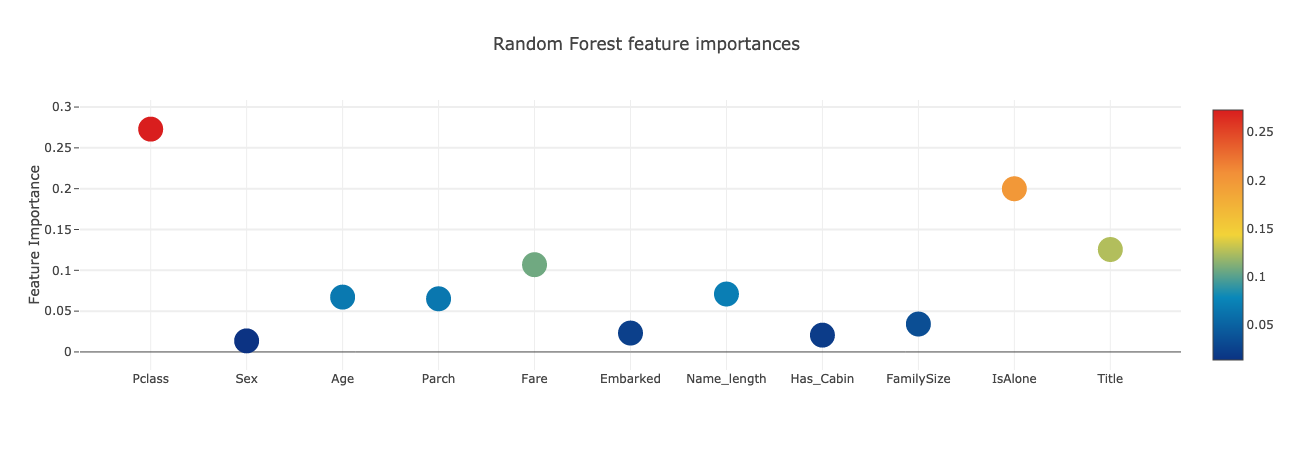

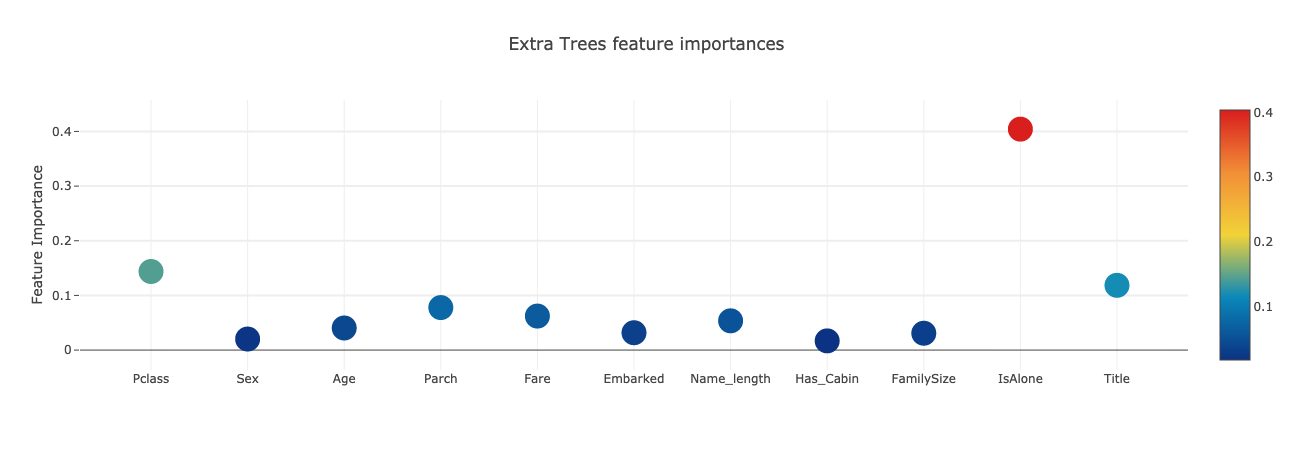

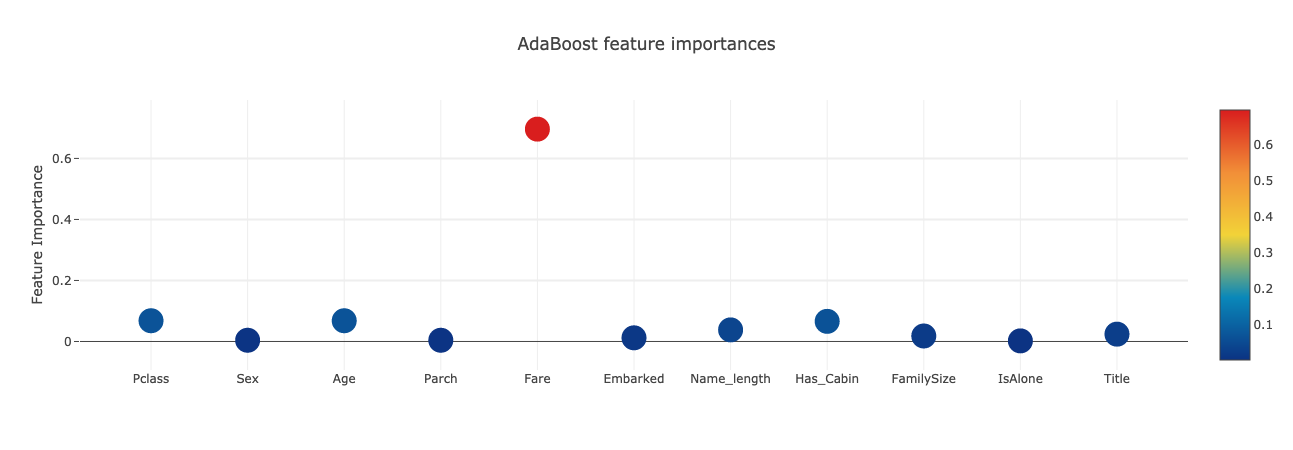

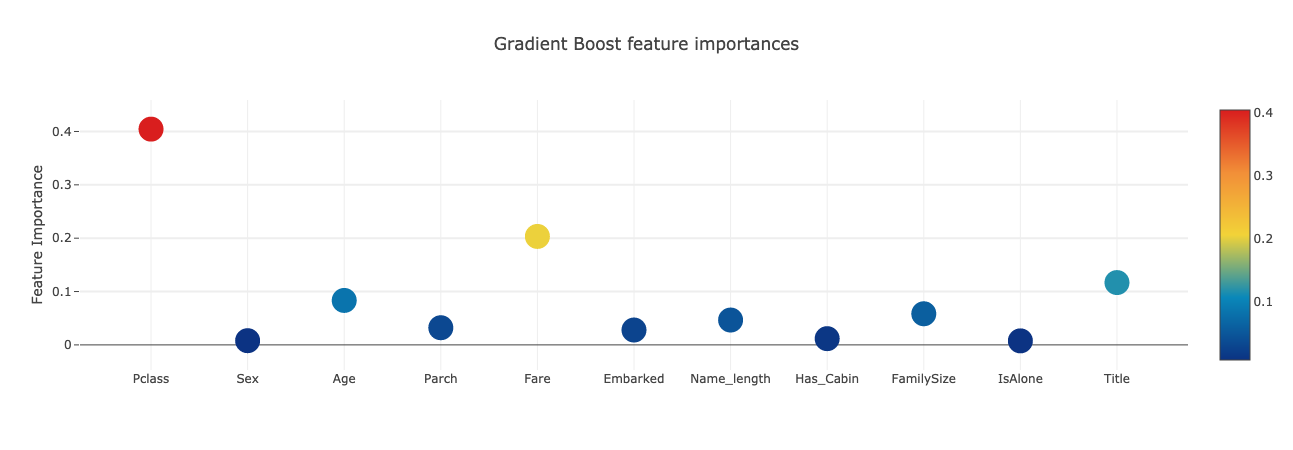

In [20]:
# Scatter plot
for name in feature_names:
    trace = go.Scatter(
        y=feature_dataframe[name].values,
        x=feature_dataframe['features'].values,
        mode='markers',
        marker=dict(
            sizemode='diameter',
            sizeref=1,
            size=25,
            color=feature_dataframe[name].values,
            colorscale='Portland',
            showscale=True
        ),
        text=feature_dataframe['features'].values
    )
    
    data = [trace]

    layout = go.Layout(
        autosize=True,
        title=name,
        hovermode='closest',
        yaxis=dict(
            title='Feature Importance',
            ticklen=5,
            gridwidth=2
        ),
        showlegend=False
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='scatter2010')

In [15]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)

#### Plotly Barplot of Average Feature Importances

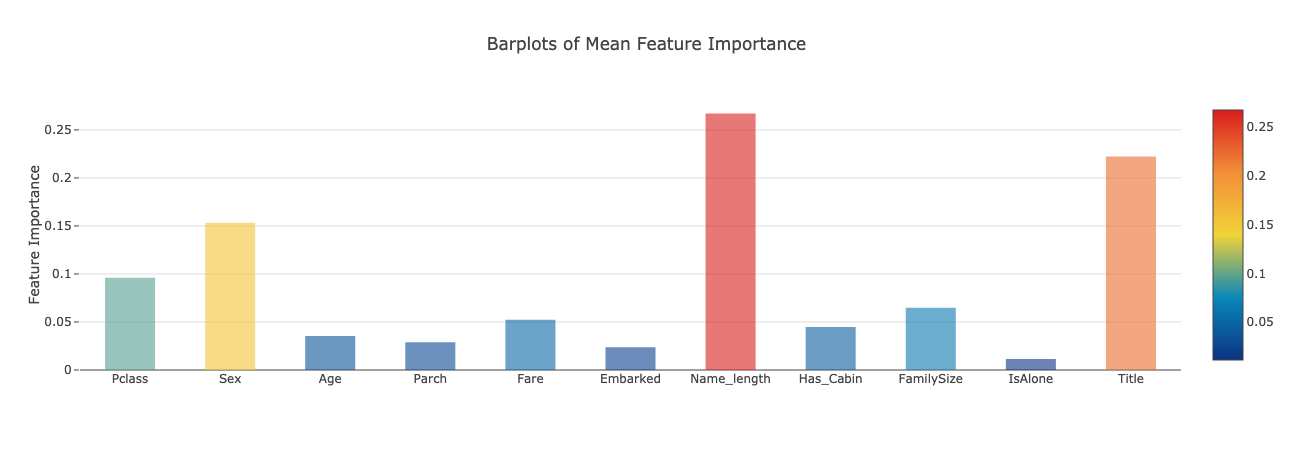

In [16]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
    x=x,
    y=y,
    width=0.5,
    marker=dict(
        color=feature_dataframe['mean'].values,
        colorscale='Portland',
        showscale=True,
        reversescale=False
    ),
    opacity=0.6
)]

layout = go.Layout(
    autosize=True,
    title='Barplots of Mean Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')